#### Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  # ignore warnings

from sklearn.preprocessing import StandardScaler #scaler
from sklearn.cluster import KMeans # to perform k-means clustering 
from sklearn.cluster import DBSCAN #DBSCAN 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score # to get diferent metric scores
from scipy.spatial.distance import cdist  # to compute distances
from scipy.spatial.distance import pdist # to compute distance
from yellowbrick.cluster import SilhouetteVisualizer # to visualize the elbow curve and silhouette scores





In [2]:
# histogram and boxplot for the feature
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="orange"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="Winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(data[feature].median(), color="blue", linestyle="-")
    plt.show()  # show the plot

# labeled_barplot
def labeled_barplot(data, feature, perc=False, v_ticks=True, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    if v_ticks is True:
        plt.xticks(rotation=90)
        
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage
    plt.show()  # show the plot

In [3]:
#loading the required dataset
df = pd.read_csv('Customerinfo.csv')
df

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
...,...,...,...,...,...,...,...
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0


In [4]:
# back up data
df_back = df.copy()

In [5]:
#Check the dimension of the dataset
df.shape


(660, 7)

#### DATA PREPROCESSING

In [6]:
# Check the datatypes of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


- The dataset has no categorical / object columns.
- The "Customer Key" column name has a space in between. Will update to remove space.

In [7]:
# fixing column names
#df.columns = [c.replace(" ", "_") for c in df.columns]
df.columns

Index(['Sl_No', 'Customer Key', 'Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'],
      dtype='object')

In [8]:
# check the count for unique records
gb_cccd = df.groupby("Customer Key").count()
gb_cccd.loc[gb_cccd.Total_calls_made >=2].shape[1]

6

In [9]:
# loop through and display the duplicate entries
for k in list(gb_cccd.loc[gb_cccd.Total_calls_made >=2].index):
    display(df.loc[df["Customer Key"] == k])

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


In [10]:
#Checking for column duplication in the dataset
df.columns.duplicated()

array([False, False, False, False, False, False, False])

In [11]:
#Checking for row duplication in the dataset
df.duplicated().sum()

0

In [12]:
# checking for nan values
df.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [13]:
# checking for missing value
df.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [14]:
# checking for any missing value at all
df.isnull().values.any()

False

- There are no missng value in each of the column; also there are no nan value.

In [15]:
# checking for unique data
df.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

-There are unique value in each of the column of the dataset.

In [16]:
#Performing descriptive statistics on the dataset
df.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


- The Credit_Limit has big scale ranging from 3000 to 200000
- 50% of the customers has 5 Credit_Card, with atleast some customers having 1 Credit_Card while some with 10 Credit_Cards.
- On an average, customers visited the bank in person 2.4 times.
- On an average, customers visited the bank's portal(online) 2.6 times.
- On an average, Customers have called the bank 3.5times.
- Also, there are customers who have never contacted the bank by any means. That is do not visit the bank, log in online or even make calls to the customer service department

#### EXPLORATORY DATA ANALYSIS

In [17]:
# The first and second coumn in the dataset are unnecessary and should be dropped
df.drop(df.columns[[0,1]], axis=1, inplace=True)

<Figure size 1200x825 with 0 Axes>

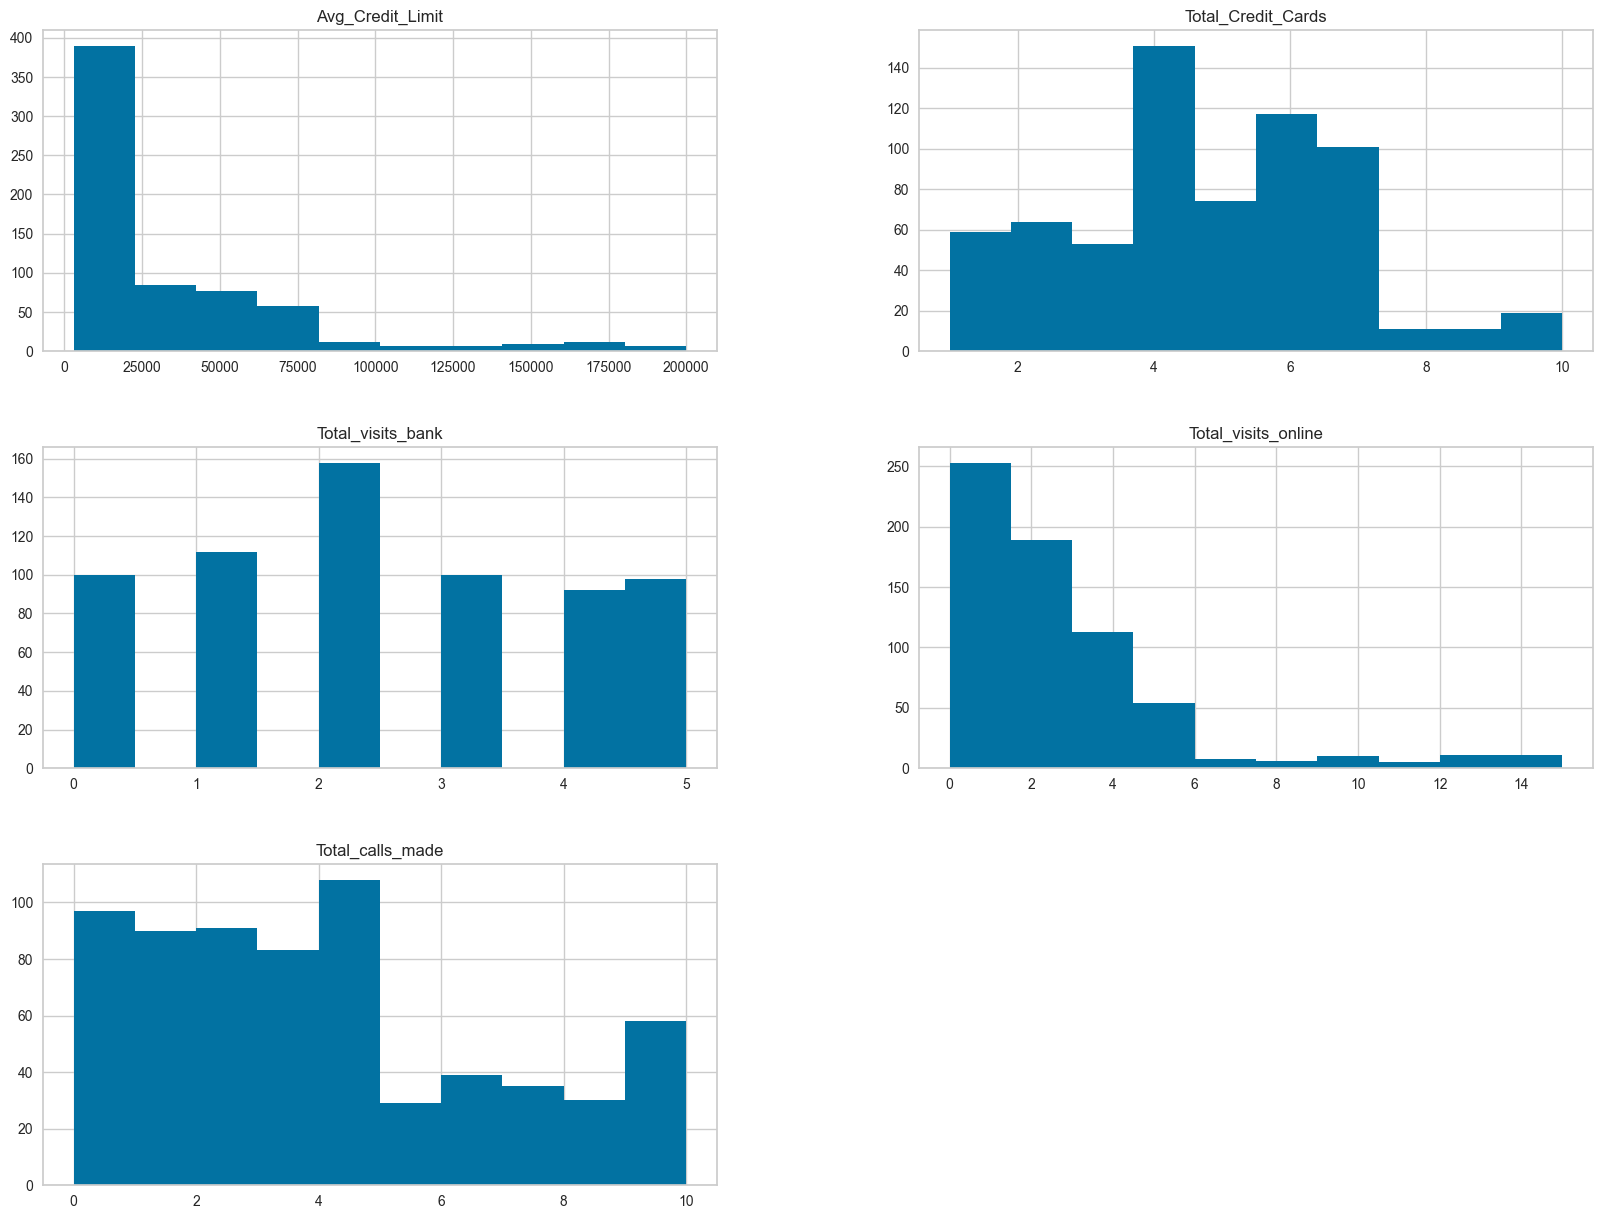

In [18]:
plt.figure(dpi=150) 
df.hist(figsize = (20,15)) 
plt.show() 

##### Univariate Analysis

In [19]:
def histogram_boxplot(feature, figsize=(15, 7), bins=None):
    """ 
    Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (15,10))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='yellow') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=True, ax=ax_hist2, bins=bins) if bins else sns.distplot(feature, kde=True, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='blue', linestyle='-');# Add median to the histogram

In [20]:
def create_outliers(feature: str, df=df):
    """ 
    Returns dataframe object of feature outliers.
    feature: 1-d feature array
    df: pandas dataframe (default is data)
    """
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    #print(((df.Mileage < (Q1 - 1.5 * IQR)) | (df.Mileage > (Q3 + 1.5 * IQR))).sum())
    return df[((df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR)))]

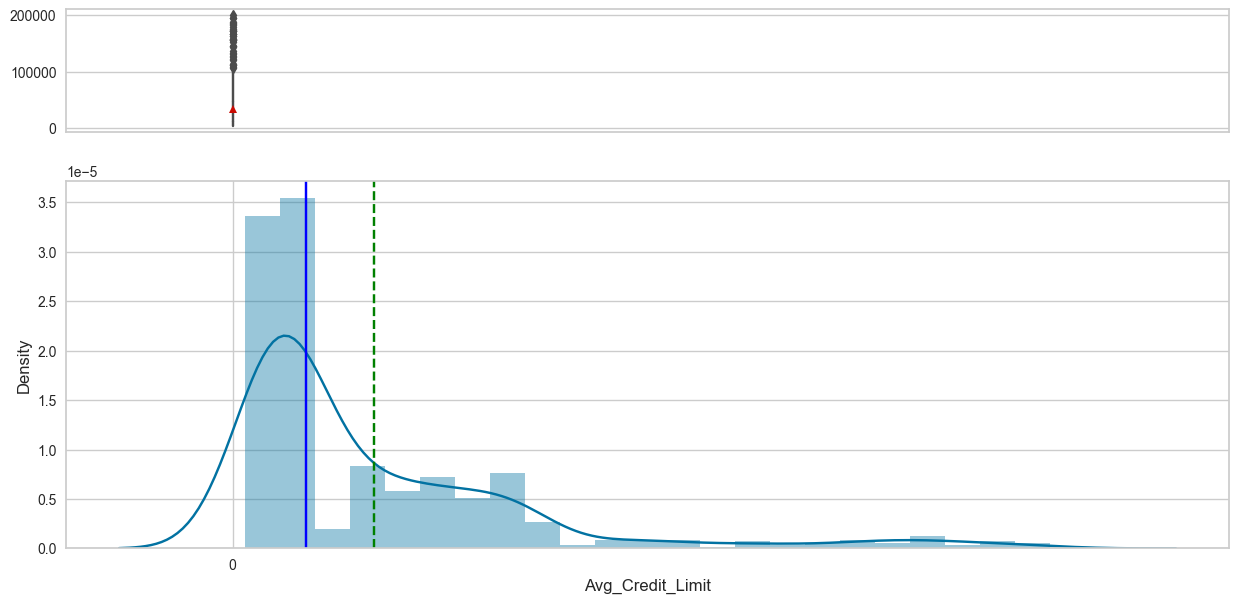

In [21]:
histogram_boxplot(df.Avg_Credit_Limit)

- From the records,many do not have credit or have a low credit limit.

- This appears normally didtributed; many customers have more than one credit card


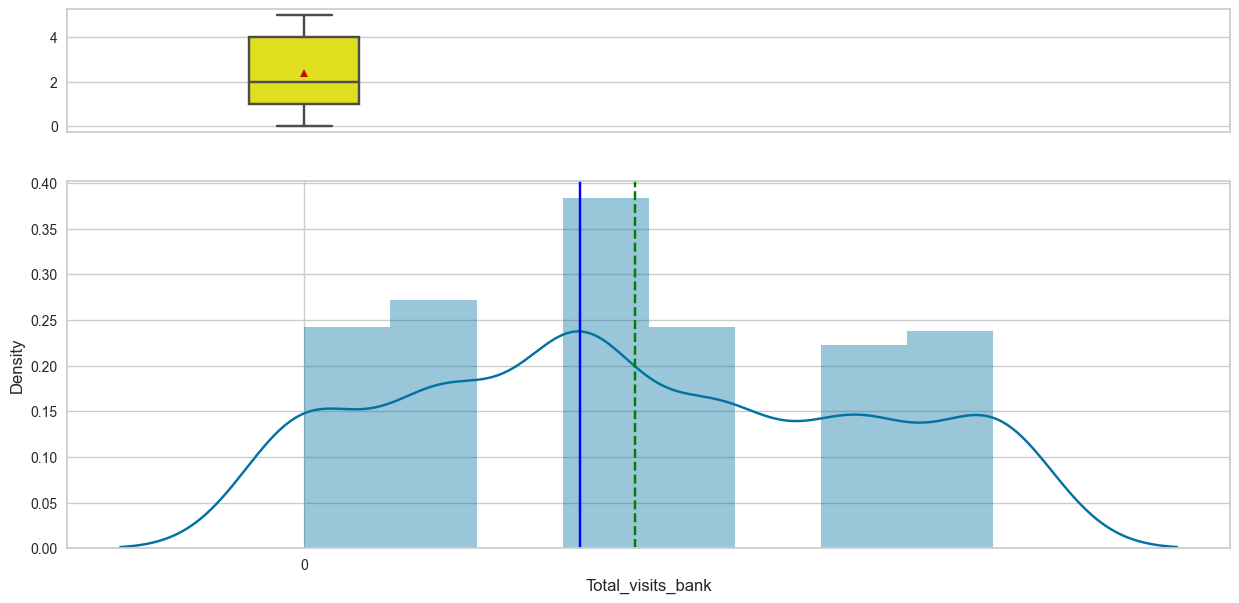

In [22]:
histogram_boxplot(df.Total_visits_bank)

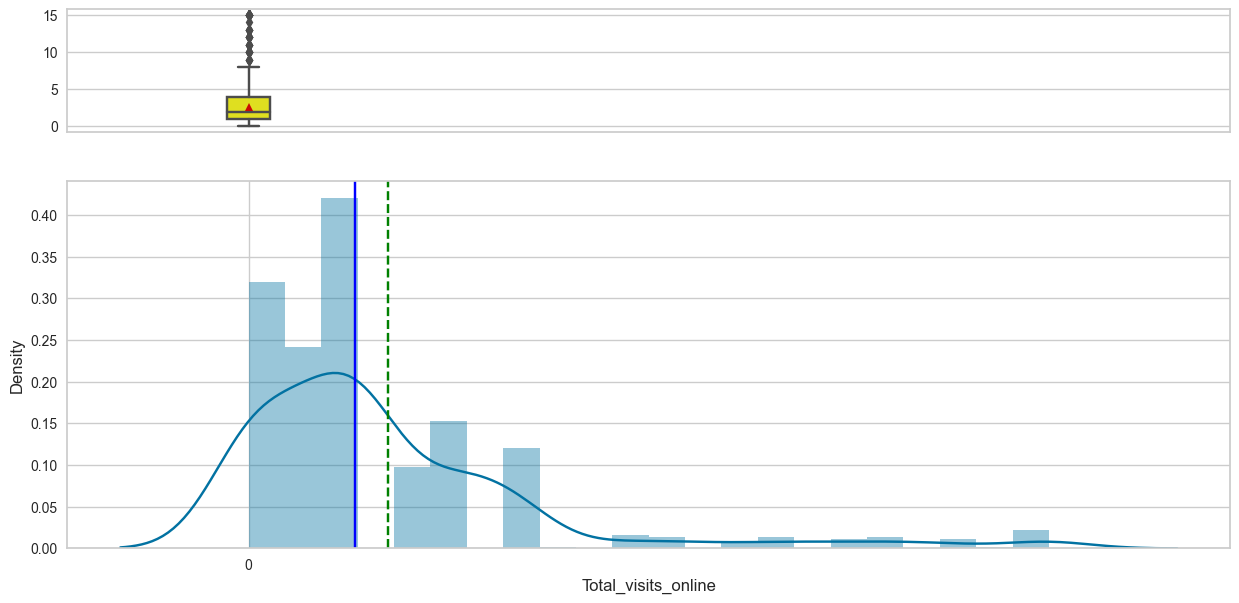

In [23]:
histogram_boxplot(df.Total_visits_online)

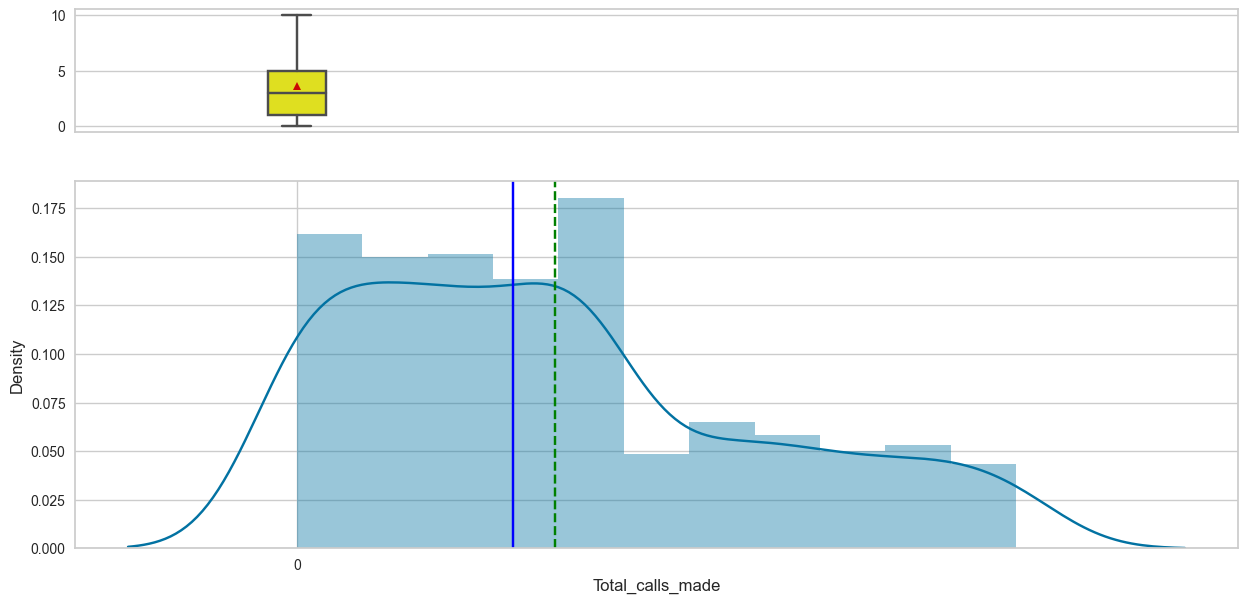

In [24]:
histogram_boxplot(df.Total_calls_made)

##### Bivariate Analysis
- This plot is done to see the amount of feature interaction present.

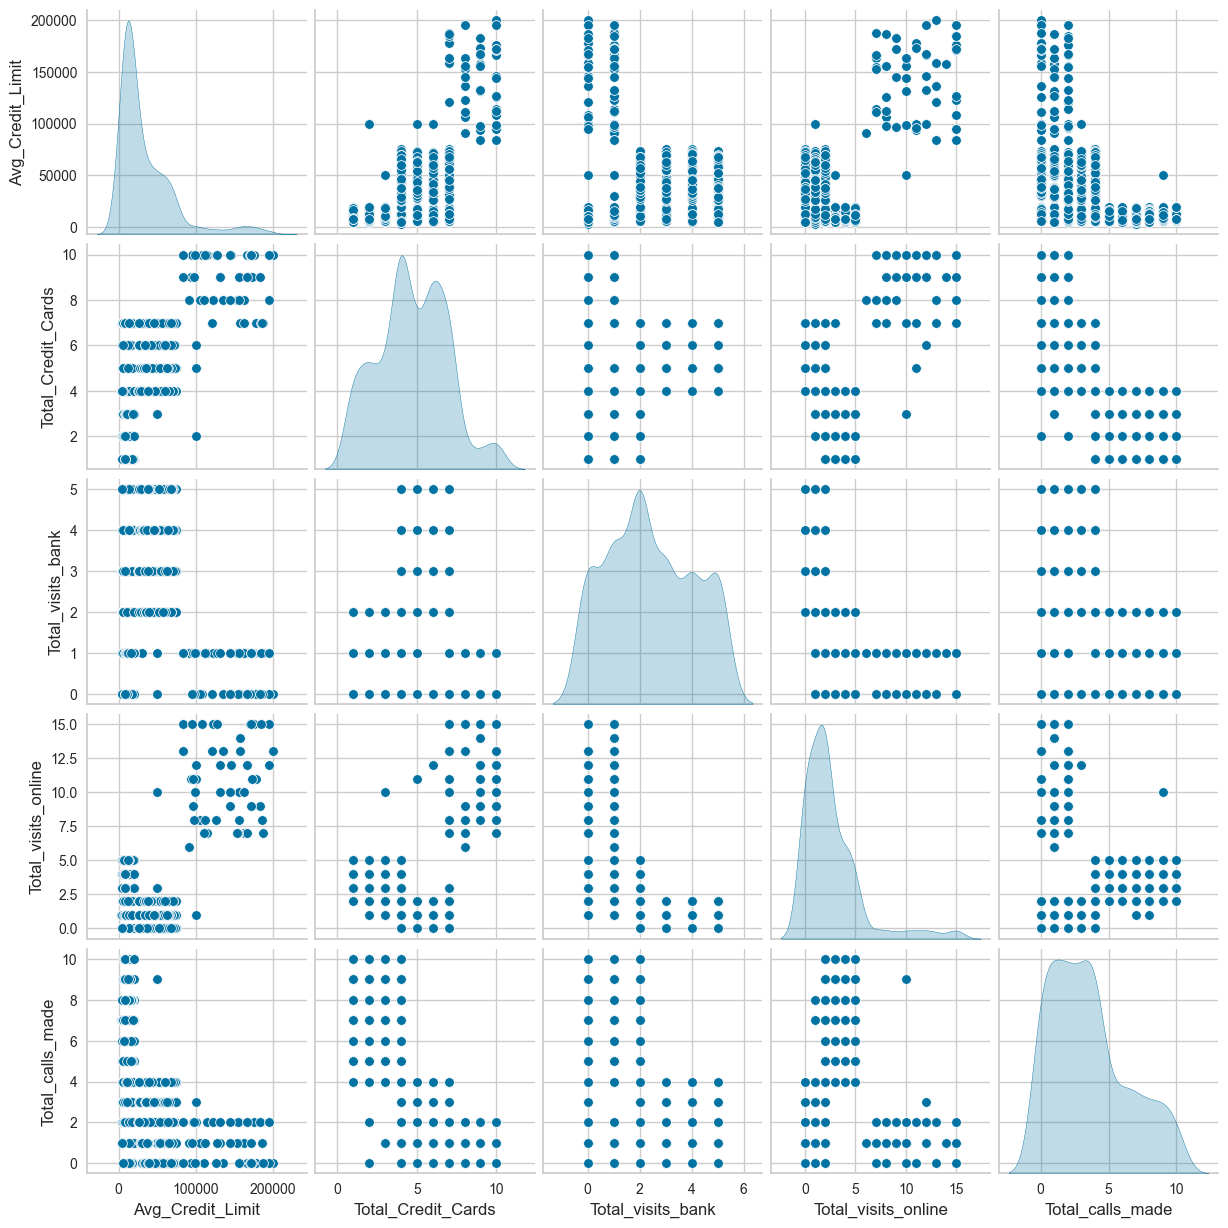

In [25]:
 sns.pairplot(df[['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']], diag_kind='kde');

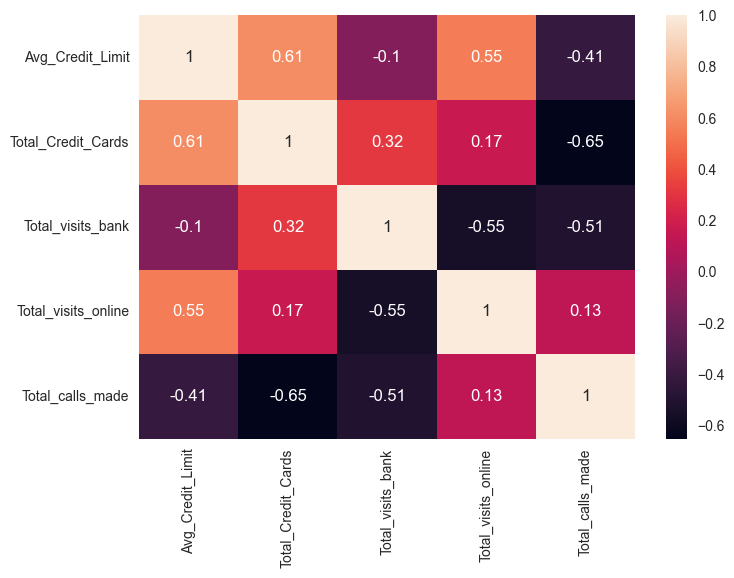

In [26]:
sns.heatmap(df[['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']].corr(), annot=True);

- There is a positive correlation of Total_Credit_Cards and Total_visits_online with Average_Credit_Limit; 0.61,0.55
- There is a negative correlation of Total_Credit_Cards and Total_visits_bank with Total_calls_made; -0.65,-0.51
- There is a negative correlation of Total_visits_online with Total_visits_bank; -0.55
- As the Average credit limit increases, the phone calls made and visits to the bank decreases.
- As credit limit increases, the online banking also increases.

##### Prepare Data for Clustering
#### Scale the data for clustering

In [27]:
# scaling the dataset before clustering
scaler = StandardScaler()
subset = df.copy()
subset_scaled = scaler.fit_transform(subset)

# creating a dataframe of the scaled columns for clustering
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

##### K-Means Clustering
#### Find the approriate value for K using Kmeans

In [28]:
# define cluster range
clusters = range(1, 10)
meanDistortions = []

# loop through the clusters
for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9429789712808515
Number of Clusters: 7 	Average Distortion: 0.9091362001500471
Number of Clusters: 8 	Average Distortion: 0.8923376884458283
Number of Clusters: 9 	Average Distortion: 0.8678650952756373


##### Plot the Elbow Curve

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

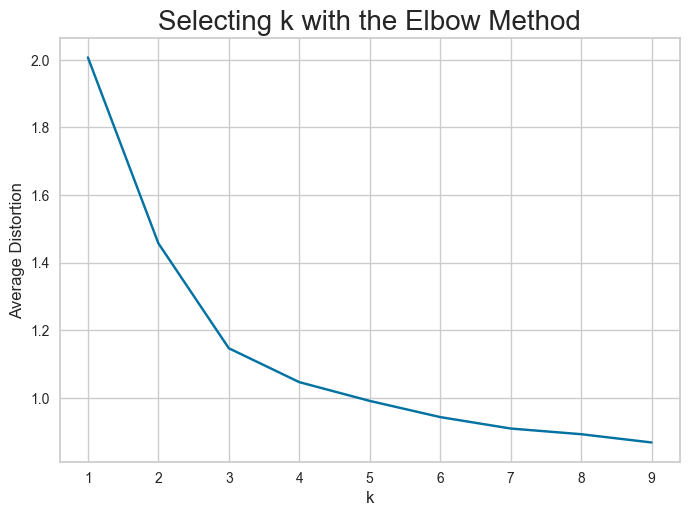

In [29]:
# plot elbow graph
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

- From the graph, the right value for K seems to be 3 and 4

##### Check the sihouette scores

In [30]:
# check the silhouette scores
sil_score_km = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score_km.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2717470361089752
For n_clusters = 6, silhouette score is 0.2554668170859757
For n_clusters = 7, silhouette score is 0.23443538156296403
For n_clusters = 8, silhouette score is 0.22341536201071743
For n_clusters = 9, silhouette score is 0.22672143246932697


##### Plot a graph for Silhouette Scores

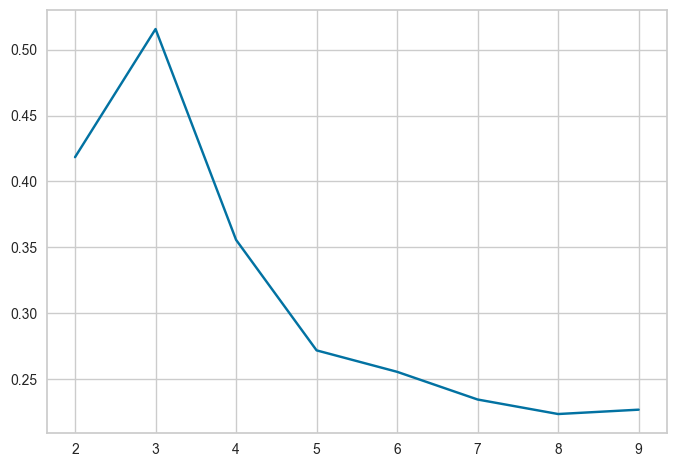

In [31]:
# plot the graph
plt.plot(cluster_list, sil_score_km)

- 3 clusters gives highest score and appears to be the optimum K

##### Finding the optimum number of clusters

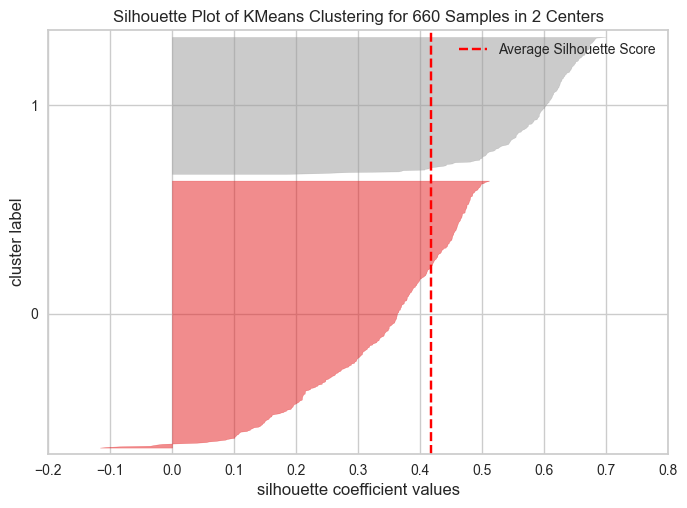

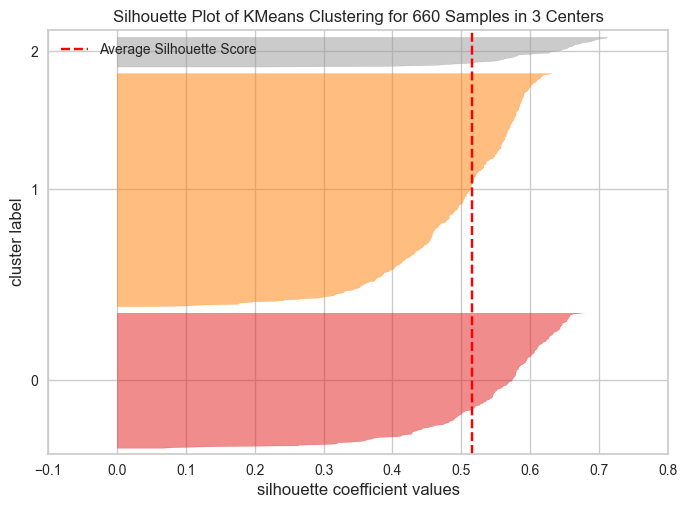

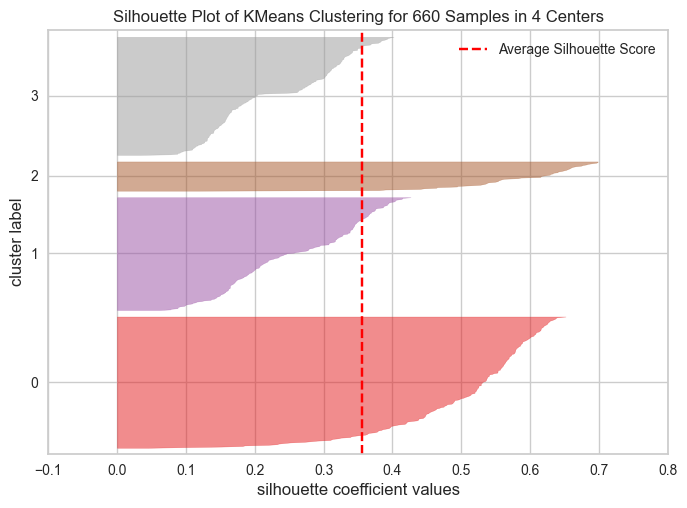

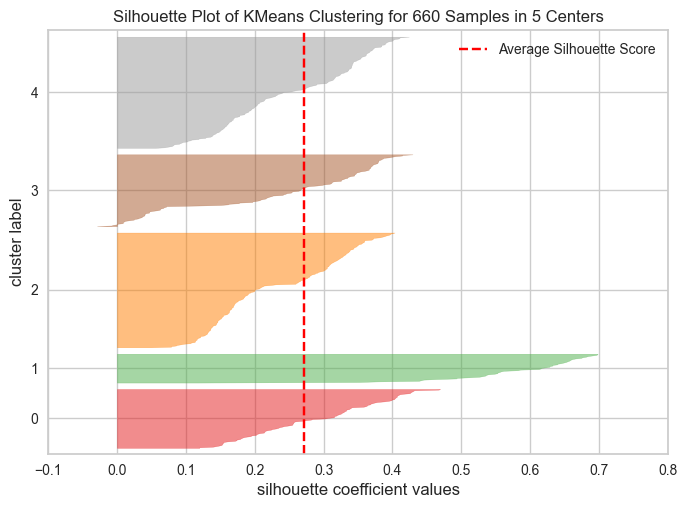

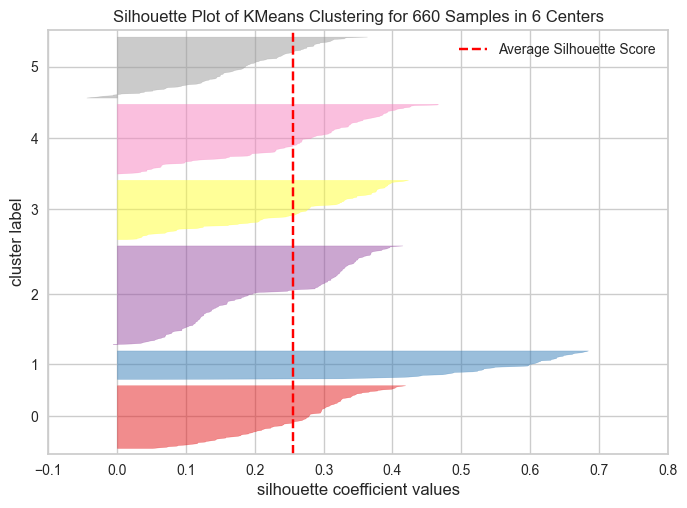

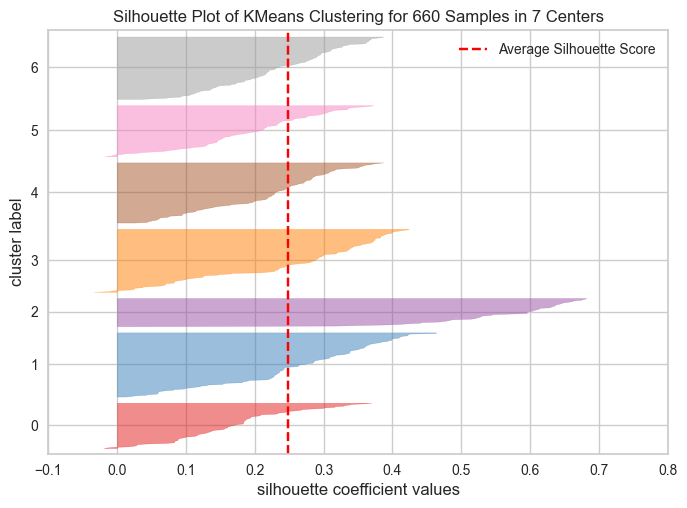

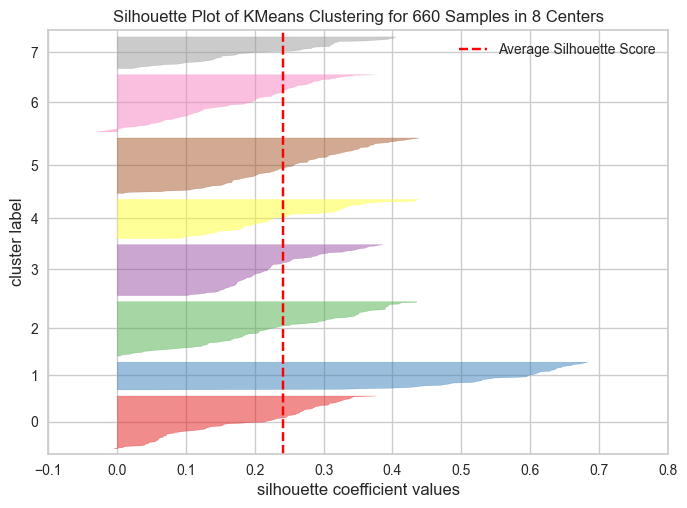

In [32]:
# finding optimum number of clusters with silhouette coefficients
num_list = list(range(2, 9))
for num in num_list:
    visualizer = SilhouetteVisualizer(KMeans(num, random_state=1))
    visualizer.fit(subset_scaled_df)
    visualizer.show()

- The silhouette score is high enough for 3.
- The elbow curve shows the curve starts normalising at 3

##### Kmeans for 3 clusters

In [33]:
# fit kmeans for 3 clusters
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(subset_scaled_df)

# adding kmeans cluster labels to the original dataframe
df["KM_Clusters"] = kmeans.labels_

# find mean for each group
cluster_profile = df.groupby("KM_Clusters").mean()

# counts for each group
cluster_profile["count_in_each_segment"] = (
    df.groupby("KM_Clusters")["Customer Key"].count().values
)

# let"s display cluster profiles
cluster_profile.style.highlight_max(color="green", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
KM_Clusters,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


##### From cluster profile,
- Cluster 0 shows the lowest value for Avg_Credit_Limit & Total_Credit_Cards.
- Cluster 0 shows the highest value for Total_calls_made.
- Cluster 0 shows 34% customers.
- Cluster 1 shows the highest value for Total_visits_bank.
- Cluster 1 shows the lowest value for Total_visits_online.
- Cluster 1 shows 58.5% customers.
- Cluster 2 shows the highest value for Avg_Credit_Limit,Total_Credit_Cards & Total_visits_online.
- Cluster 2 shows the lowest value for Total_visits_bank.
- CLuster 2 shows 7.5% of customers.

